In [1]:
import torch.nn as nn

ann = nn.Sequential(
    nn.Conv2d(1, 20, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    nn.Conv2d(20, 32, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    nn.Conv2d(32, 128, 3, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(128, 500, bias=False),
    nn.ReLU(),
    nn.Linear(500, 10, bias=False),
)

In [2]:
import torch
from torchvision import datasets, transforms


class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, is_spiking=False, time_window=100):
        super().__init__(
            root=root, train=train, download=True, transform=transforms.ToTensor()
        )
        self.is_spiking = is_spiking
        self.time_window = time_window

    def __getitem__(self, index):
        img, target = self.data[index].unsqueeze(0) / 255, self.targets[index]
        # img is now a tensor of 1x28x28

        if self.is_spiking:
            img = (torch.rand(self.time_window, *img.shape) < img).float()

        return img, target

In [4]:
from torch.utils.data import DataLoader

mnist_train = MNIST("dataset/", train=True, is_spiking=False)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

mnist_test = MNIST("dataset/", train=False, is_spiking=False)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

In [7]:
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

ann = ann.to(device)
ann.train()

optim = torch.optim.Adam(ann.parameters(), lr=1e-3)

n_epochs = 3

for n in tqdm(range(n_epochs)):
    for data, target in iter(train_loader):
        data, target = data.to(device), target.to(device)
        output = ann(data)
        optim.zero_grad()

        loss = F.cross_entropy(output, target)
        loss.backward()
        optim.step()

100%|████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.85s/it]


In [8]:
correct_predictions = []

for data, target in iter(test_loader):
    data, target = data.to(device), target.to(device)
    output = ann(data)

    # get the index of the max log-probability
    pred = output.argmax(dim=1, keepdim=True)

    # Compute the total correct predictions
    correct_predictions.append(pred.eq(target.view_as(pred)))

correct_predictions = torch.cat(correct_predictions)
print(
    f"Classification accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%"
)

Classification accuracy: 98.64%


In [9]:
from sinabs.from_torch import from_model

input_shape = (1, 28, 28)
num_timesteps = 100  # per sample

sinabs_model = from_model(
    ann, input_shape=input_shape, add_spiking_output=True, synops=False, num_timesteps=num_timesteps
)

In [10]:
sinabs_model.spiking_model

Sequential(
  (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (1): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1., device='cuda:0'), min_v_mem=Parameter containing:
  tensor(-1., device='cuda:0'), batch_size=-1, num_timesteps=100)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (4): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1., device='cuda:0'), min_v_mem=Parameter containing:
  tensor(-1., device='cuda:0'), batch_size=-1, num_timesteps=100)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (7): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1., device='cuda:0'), min_v_mem=Parameter containing:
  tensor(-1., device='cuda:0'), batch_size=-1, num_timesteps=100)
  (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=

In [11]:
test_batch_size = 10

spike_mnist_test = MNIST(
    "dataset/", train=False, is_spiking=True, time_window=num_timesteps
)
spike_test_loader = DataLoader(
    spike_mnist_test, batch_size=test_batch_size, shuffle=True
)

In [12]:
import sinabs.layers as sl

correct_predictions = []

for data, target in tqdm(spike_test_loader):
    data, target = data.to(device), target.to(device)
    data = sl.FlattenTime()(data)
    with torch.no_grad():
        output = sinabs_model(data)
        output = output.unflatten(
            0, (test_batch_size, output.shape[0] // test_batch_size)
        )

    # get the index of the max log-probability
    pred = output.sum(1).argmax(dim=1, keepdim=True)

    # Compute the total correct predictions
    correct_predictions.append(pred.eq(target.view_as(pred)))
    if len(correct_predictions) * test_batch_size >= 300:
        break

correct_predictions = torch.cat(correct_predictions)
print(
    f"Classification accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%"
)

  3%|█▎                                          | 29/1000 [00:02<01:27, 11.07it/s]

Classification accuracy: 97.66666666666667%


In [13]:
img, label = spike_mnist_test[10]

In [14]:
img.shape

torch.Size([100, 1, 28, 28])

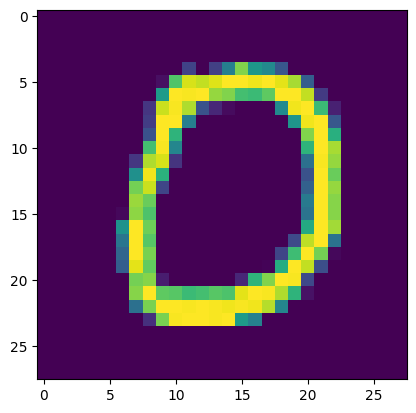

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.imshow(img.sum(0)[0]);

In [16]:
snn_output = sinabs_model(img.to(device))

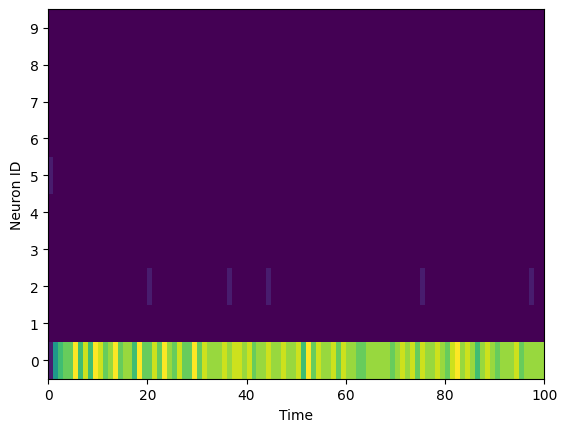

In [17]:
import numpy as np

plt.pcolormesh(snn_output.T.detach().cpu())

plt.ylabel("Neuron ID")
plt.yticks(np.arange(10) + 0.5, np.arange(10))
plt.xlabel("Time");